## Task 2: Aspect Based Sentiment Analysis

##### References:
- [Hugging Face: Generate BERT Embeddings](https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958)
- [Hugging Face: Size of embedding vectors](https://discuss.huggingface.co/t/huggingface-dataset-each-element-in-list-of-batch-should-be-of-equal-size/10697/6)
- [Medium: Finetune BERT](https://medium.com/@xiaohan_63326/fine-tune-fine-tuning-bert-for-sentiment-analysis-f5002b08f10a)
- [Medium: Finetune Roberta for COVID-19 Tweet Sentiment Analysis](https://davidanifowoshe.medium.com/fine-tuning-roberta-for-covid-19-tweet-sentiment-classification-4063b85ff2e3)
- [Github: Finetune Roberta for Sentiment Analysis](https://github.com/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb)
- [Medium: Finetune BART as chat summarizer](https://medium.com/@ferlatti.aldo/fine-tuning-a-chat-summarizer-c18625bc817d)

In [7]:
# Import all libraries
import json
import re
import os
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification
from transformers import AdamW, get_scheduler
from transformers import BartForSequenceClassification
from transformers import BartTokenizer
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import BertTokenizer
import warnings

In [2]:
warnings.filterwarnings("ignore")

### Task 2.2: Preprocessing

In [8]:
# Dataset class for Aspect Based Sentiment Analysis using our LSTM model
class ABSADataset(Dataset):
    def __init__(self, file_path, saved_file_path = None):
        """
        Initialize the dataset by loading and preprocessing the data.
        """
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
        self.model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)
        if saved_file_path is not None and os.path.exists(saved_file_path):
            with open(saved_file_path, 'r') as f:
                self.data = json.load(f)  # Load preprocessed data from the saved file
            print("Preprocessed data loaded from", saved_file_path)
        else:
            with open(file_path, 'r') as f:
                raw_data = json.load(f)  # Load raw JSON data from given file
            self.data = self.preprocess_data(raw_data)  # Preprocess and store in self.data
            if saved_file_path is not None:
                with open(saved_file_path, 'w') as f:
                    json.dump(self.data, f, indent=4)  # Save preprocessed data in the file path
                print("Preprocessed data saved to", saved_file_path)

    """
    Preprocessing rule (Assumptions taken):
    - Extract the index of each token in the original sentence by taking multiple spaces into account
    - Remove leading and trailing punctuation like ,.!()-{}[]"";:
    - Remove single quotes
    - Skip words that become empty (which means they were only punctuation)
    - Allow an error range of +/- 2 tokens when matching the aspect term
    - Check if the token's prefix matches the start of the aspect term
    - Return -1 if no match is found
    """

    def preprocess_data(self, data):
        """
        Tokenizes and processes data into required format.
        """
        preprocessed_data = []
        for d in data:
            tokens = self.tokenize_data(d["sentence"])
            for term in d['aspect_terms']:
                new_data = {
                    "tokens": [t[0] for t in tokens],  # Extract token words
                    "polarity": term["polarity"],
                    "aspect_term": [term["term"]],
                    "index": self.find_aspect_index(tokens, int(term["from"]), term["term"])
                }
                preprocessed_data.append(new_data)
        return preprocessed_data

    def tokenize_data(self, sentence):
        """
        Tokenizes sentence while preserving exact indices according to raw data.
        
        We tokenize manually to handle all the different cases that have been included in the given files.
        """
        tokens_idx = []
        i = 0
        word = ''
        start_idx = -1

        while i < len(sentence):
            while i < len(sentence) and sentence[i] != ' ':
                if not word:
                    start_idx = i
                word += sentence[i]
                i += 1
            if word:
                tokens_idx.append((word, start_idx))
            word = ''
            i += 1

        return self.clean_tokens(tokens_idx)

    def clean_tokens(self, tokens_idx):
        """
        Cleans tokens by removing punctuation and handling contractions.
        """
        cleaned_tokens = []
        for word, idx in tokens_idx:
            stripped_word = re.sub(r'^[.!(),\[\]{}\'":;-]+|[.!(),\[\]{}\'":;-]+$', '', word)
            stripped_word = stripped_word.replace("'", "")

            if stripped_word:
                cleaned_tokens.append((stripped_word.lower(), idx))
        return cleaned_tokens

    def find_aspect_index(self, tokens, aspect_from, aspect_term):
        """
        Finds the token index corresponding to the aspect term with an error range of +/-2.
        """
        aspect_term = self.tokenize_data(aspect_term)
        for i in range(len(tokens)):
            if aspect_from - 2 <= tokens[i][1] <= aspect_from + 2:
                if tokens[i][0].startswith(aspect_term[0][0]):  # Check prefix match
                    return i
        return -1

    def get_token_embeddings(self, tokens, max_length=128, layers=[-4, -3, -2, -1]):
        """
        Get BERT embeddings for a list of tokens, ensuring a fixed shape of (max_length, 768).
        
        We use BERT since BERT is contextual and can capture the meaning of the words better.
        """
        encoded = self.tokenizer(
            tokens,
            return_tensors="pt",
            is_split_into_words=True,
            padding="max_length",
            truncation=True,
            max_length=max_length,
        )

        with torch.no_grad():
            output = self.model(**encoded)

        # Compute embeddings (sum last 4 layers as these capture the most information)
        hidden_states = torch.stack([output.hidden_states[i] for i in layers]).sum(0).squeeze()

        # Ensure final shape is (max_length, 768)
        if hidden_states.shape[0] < max_length:
            pad_size = max_length - hidden_states.shape[0]
            pad_tensor = torch.zeros((pad_size, hidden_states.shape[1]))  # (pad_size, 768)
            hidden_states = torch.cat([hidden_states, pad_tensor], dim=0)  # Pad at the end

        return hidden_states[:max_length]  # (max_length, 768)

    def __len__(self):
        """
        Returns the total number of data samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns a single preprocessed data sample, including computed embeddings.
        """
        sample = self.data[idx]
        polarity_map = {"positive": 0, "neutral": 2, "negative": 1, "conflict": 3}

        # Get sentence embeddings (shape: (max_length, 768))
        embeddings = self.get_token_embeddings(sample["tokens"], max_length=128)

        # Get aspect term embeddings (shape: (aspect_max_length, 768))
        aspect_tokens = self.tokenize_data(sample["aspect_term"][0])
        aspect_embedding = self.get_token_embeddings([t[0] for t in aspect_tokens], max_length=8)
        return {
            "tokens": sample["tokens"],
            "embeddings": torch.tensor(embeddings, dtype=torch.float),  # Shape: (128, 768)
            "polarity": torch.tensor(polarity_map[sample["polarity"]], dtype=torch.long),  # Shape: ()
            "aspect_term":  torch.tensor(aspect_embedding, dtype=torch.float), # Shape: (8, 768)
            "index": torch.tensor(sample["index"], dtype=torch.long),  # Shape: ()
        }

In [ ]:
# Path for kaggle
# train_dataset = ABSADataset("train.json", "/kaggle/input/dataset/train_task_2.json")
# val_dataset = ABSADataset("val.json", "/kaggle/input/dataset/val_task_2.json")

# Path for local
train_dataset = ABSADataset("train.json", "train_task_2.json")
val_dataset = ABSADataset("val.json", "val_task_2.json")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Preprocessed data loaded from /kaggle/input/dataset/train_task_2.json
Preprocessed data loaded from /kaggle/input/dataset/val_task_2.json


In [ ]:
# Check the maximum length of the sentences to set the max_length parameter
max_train_length = max([len(d["tokens"]) for d in train_dataset.data])
max_val_length = max([len(d["tokens"]) for d in val_dataset.data])
print("Max train length:", max_train_length)
print("Max val length:", max_val_length)

Max train length: 69
Max val length: 48


In [ ]:
# Verify the dataset
print(len(train_dataset))
print(len(val_dataset)) 
print(train_dataset[0])
print(val_dataset[0])  

2961
371


<ipython-input-19-aaa2431169f3>:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "embeddings": torch.tensor(embeddings, dtype=torch.float),  # Shape: (128, 768)
<ipython-input-19-aaa2431169f3>:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "aspect_term":  torch.tensor(aspect_embedding, dtype=torch.float),


{'tokens': ['But', 'the', 'staff', 'was', 'so', 'horrible', 'to', 'us'], 'embeddings': tensor([[ 1.9976,  3.0614, -2.7381,  ..., -1.5977,  1.8881, -0.6945],
        [ 2.2932,  2.6890, -0.3895,  ...,  2.1881, -1.1270, -0.5891],
        [-0.4416, -0.6662, -2.2985,  ...,  1.4890, -1.8471,  3.0896],
        ...,
        [-3.3617,  1.8583, -0.7389,  ..., -0.9075, -1.0788, -2.5828],
        [-2.9848,  1.6417, -1.2289,  ..., -1.4844, -1.8254, -3.1934],
        [-3.0569,  1.6146, -1.7832,  ..., -1.0309, -2.0181, -3.6214]]), 'polarity': tensor(1), 'aspect_term': tensor([[ 0.9993, -1.1836, -1.4425,  ..., -1.0973,  1.5845,  1.2668],
        [ 2.5821, -4.1148, -0.4606,  ..., -3.3853, -0.1479,  0.3373],
        [ 0.2073,  0.8993,  0.4269,  ..., -0.0397,  0.8534, -0.5007],
        ...,
        [ 0.7302, -2.3625, -0.5775,  ..., -1.7317, -1.3500,  2.5714],
        [ 0.5361, -2.1273, -0.7241,  ..., -1.6414, -0.6824,  2.7984],
        [ 0.6539, -1.3669, -2.6095,  ..., -0.8288,  1.8169,  4.2203]]), 'inde

### Task 2.3: Model Training

In [9]:
class LSTMClassifier(nn.Module):
    """
    LSTM model for aspect-based sentiment analysis.
    """
    def __init__(self, input_dim=768, hidden_dim=256, num_layers=2, output_dim=4, dropout=0.3):
        """
        Initializes the LSTM model with given dimensions.
        """
        super(LSTMClassifier, self).__init__()
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout)        
        # Aspect FC layer: Maps aspect embeddings to hidden_dim
        self.aspect_fc = nn.Linear(input_dim, hidden_dim)
        # Fully connected layer: Maps hidden_dim * 3 to output_dim
        self.fc = nn.Linear(hidden_dim * 3, output_dim)
        # Dropout: Prevents overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, sentence_embeddings, aspect_embeddings, aspect_index):
        """
        Forward pass of the LSTM model.
        """
        lstm_out, (hidden, _) = self.lstm(sentence_embeddings)  
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Shape: (batch_size, hidden_dim * 2)
        aspect_rep = aspect_embeddings.mean(dim=1)  # Shape: (batch_size, 768)
        aspect_rep = self.aspect_fc(aspect_rep)  # **Maps (batch_size, 768) → (batch_size, 256)**
        combined = torch.cat((hidden, aspect_rep), dim=1)  # Shape: (batch_size, hidden_dim * 3)
        out = self.fc(self.dropout(combined))
        return out

In [ ]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, patience=3):
    """
    Trains the given model using the train and validation loaders.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    best_acc = 0.0
    best_loss = float('inf')
    patience_counter = 0  # Early stopping counter

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for sentence_embeddings, aspect_embeddings, labels, aspect_index in tqdm_bar:
            # Embeddings and labels to device
            sentence_embeddings = sentence_embeddings.to(device)
            aspect_embeddings = aspect_embeddings.to(device)
            labels = labels.to(device)
            aspect_index = aspect_index.to(device)

            optimizer.zero_grad()
            outputs = model(sentence_embeddings, aspect_embeddings, aspect_index)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tqdm_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_acc = correct / total
        train_accuracy.append(train_acc)
        train_loss.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_total_loss, correct, total = 0, 0, 0

        tqdm_bar_val = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}", leave=False)
        with torch.no_grad():
            for sentence_embeddings, aspect_embeddings, labels, aspect_index in tqdm_bar_val:
                sentence_embeddings = sentence_embeddings.to(device)
                aspect_embeddings = aspect_embeddings.to(device)
                labels = labels.to(device)
                aspect_index = aspect_index.to(device)

                outputs = model(sentence_embeddings, aspect_embeddings, aspect_index)
                loss = criterion(outputs, labels)
                val_total_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                tqdm_bar_val.set_postfix(loss=f"{loss.item():.4f}")

        val_acc = correct / total
        val_accuracy.append(val_acc)
        avg_val_loss = val_total_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss[-1]:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f}")

        # Early Stopping Check
        if avg_val_loss < best_loss:
            # Save the best model with lowest validation loss
            best_loss = avg_val_loss
            best_acc = val_acc
            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), "best_lstm_model.pth")
            print("Best model saved!")
        else:
            patience_counter += 1  # Increase counter
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}! Stopping training.")
            break  # Stop training

    print(f"Training complete. Best Validation Accuracy: {best_acc:.4f}")
    return train_loss, val_loss, train_accuracy, val_accuracy

In [ ]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    """
    Plot the training and validation loss
    """
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.ylim(0, max(max(train_loss), max(val_loss)) * 1.1)
    plt.xticks(epochs)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def collate_fn(batch):
    """
    Custom collate function to batch fixed-length embeddings for ABSADataset.
    """
    sentence_embeddings = torch.stack([item["embeddings"] for item in batch])  # (batch_size, 128, 768)
    aspect_embeddings = torch.stack([item["aspect_term"] for item in batch])  # (batch_size, 8, 768)
    labels = torch.tensor([item["polarity"] for item in batch], dtype=torch.long)  # (batch_size,)
    indices = torch.tensor([item["index"] for item in batch], dtype=torch.long)  # (batch_size,)
    return sentence_embeddings, aspect_embeddings, labels, indices


In [ ]:
# Training and validation loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [10]:
model = LSTMClassifier()
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, epochs=10, lr=0.001)

Epoch 1/10 - Train Loss: 0.9113 - Train Acc: 0.6528 - Val Loss: 0.9254 - Val Acc: 0.6523
Best model saved!


Epoch 2/10 - Train Loss: 0.6686 - Train Acc: 0.7538 - Val Loss: 0.8630 - Val Acc: 0.6415
Best model saved!


Epoch 3/10 - Train Loss: 0.5489 - Train Acc: 0.7984 - Val Loss: 0.8906 - Val Acc: 0.6658
No improvement. Patience: 1/3


Epoch 4/10 - Train Loss: 0.4948 - Train Acc: 0.8119 - Val Loss: 0.9739 - Val Acc: 0.6631
No improvement. Patience: 2/3


Epoch 5/10 - Train Loss: 0.4358 - Train Acc: 0.8338 - Val Loss: 1.0609 - Val Acc: 0.6658
No improvement. Patience: 3/3
Early stopping triggered at epoch 5! Stopping training.
Training complete. Best Validation Accuracy: 0.6415


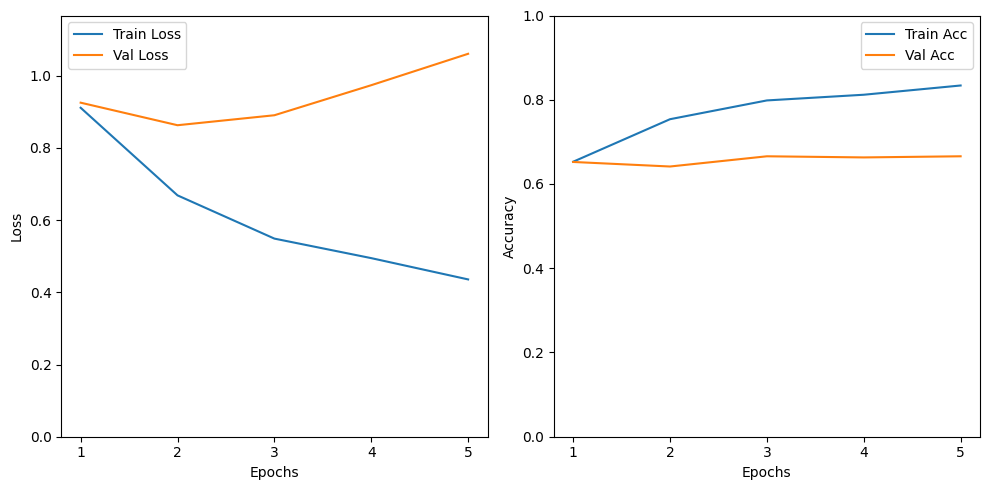

In [13]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

### Task 2.4: Evaluation
Function to evaluate the trained LSTM model on `test.json`

In [ ]:
def load_and_evaluate(model_path = "best_lstm_model.pth", test_file = "val.json", save_file = "val_task_2.json", batch_size=32):
    """
    Load the trained model and evaluate it on test data.

    Args:
        model_path (str): Path to the saved model file.
        test_file (str): Path to the test dataset.
        batch_size (int): Batch size for evaluation.

    Returns:
        float: Test accuracy.
    """

    # Load test dataset
    test_dataset = ABSADataset(test_file, save_file)    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Define model
    model = LSTMClassifier()

    # Load saved model weights
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  # Set to evaluation mode

    correct, total = 0, 0
    with torch.no_grad():
        tqdm_bar = tqdm(test_loader, desc="Evaluating")
        for sentence_embeddings, aspect_embeddings, labels, aspect_index in tqdm_bar:
            outputs = model(sentence_embeddings, aspect_embeddings, aspect_index)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

load_and_evaluate(model_path = "best_lstm_model.pth", test_file = "test.json", save_file = "test_task_2.json", batch_size=32)

### Task 2.6: Additional Task

In [16]:
class FinetuneDataset(Dataset):
    def __init__(self, model, file_path, saved_file_path = None):
        """
        Load and preprocess dataset for fine-tuning BERT, BART and Roberta models.
        """
        if model == "bert":
            self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
        elif model == "bart":
            self.tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
        elif model == "roberta":
            self.tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
        else:  
            raise ValueError("Invalid model name. Choose from 'bert', 'bart', or 'roberta'.")

        if saved_file_path is not None and os.path.exists(saved_file_path):
            with open(saved_file_path, 'r') as f:
                self.data = json.load(f)  # Load preprocessed data
            print("Preprocessed data loaded from", saved_file_path)
        else:
            with open(file_path, 'r') as f:
                raw_data = json.load(f)  # Load raw JSON data
            self.data = self.preprocess_data(raw_data)  # Preprocess and store in self.data
            if saved_file_path is not None:
                with open(saved_file_path, 'w') as f:
                    json.dump(self.data, f, indent=4)  # Save preprocessed data
                print("Preprocessed data saved to", saved_file_path) 

        self.polarity_map = {"positive": 0, "negative": 1, "neutral": 2, "conflict": 3}

    def preprocess_data(self, data):
        """
        Tokenizes and processes data into required format.
        """
        preprocessed_data = []
        for d in data:
            tokens = self.tokenize_data(d["sentence"])
            for term in d['aspect_terms']:
                new_data = {
                    "tokens": [t[0] for t in tokens],  # Extract token words
                    "polarity": term["polarity"],
                    "aspect_term": [term["term"]],
                    "index": self.find_aspect_index(tokens, int(term["from"]), term["term"])
                }
                preprocessed_data.append(new_data)
        return preprocessed_data
    
    def find_aspect_index(self, tokens, aspect_from, aspect_term):
        """
        Finds the token index corresponding to the aspect term with an error range of +/-2.
        """
        aspect_term = self.tokenize_data(aspect_term)
        for i in range(len(tokens)):
            if aspect_from - 2 <= tokens[i][1] <= aspect_from + 2:
                if tokens[i][0].startswith(aspect_term[0][0]):  # Check prefix match
                    return i
        return -1
        
    def tokenize_data(self, sentence):
        """
        Tokenizes sentence while preserving exact indices.
        """
        tokens_idx = []
        i = 0
        word = ''
        start_idx = -1

        while i < len(sentence):
            while i < len(sentence) and sentence[i] != ' ':
                if not word:
                    start_idx = i
                word += sentence[i]
                i += 1
            if word:
                tokens_idx.append((word, start_idx))
            word = ''
            i += 1

        return self.clean_tokens(tokens_idx)

    def clean_tokens(self, tokens_idx):
        """
        Cleans tokens by removing punctuation and handling contractions.
        """
        cleaned_tokens = []
        for word, idx in tokens_idx:
            stripped_word = re.sub(r'^[.!(),\[\]{}\'":;-]+|[.!(),\[\]{}\'":;-]+$', '', word)
            stripped_word = stripped_word.replace("'", "")

            if stripped_word:
                cleaned_tokens.append((stripped_word.lower(), idx))
        return cleaned_tokens

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns pre-tokenized input as BERT-compatible token IDs.
        """
        sample = self.data[idx]
        tokenized_words = sample["tokens"]
        aspect_term = sample["aspect_term"][0]
        label = self.polarity_map[sample["polarity"]]
        if isinstance(self.tokenizer, BartTokenizer):
            tokenized_words.append("</s>")

        # Convert pre-tokenized words into token IDs
        input_ids = self.tokenizer.convert_tokens_to_ids(tokenized_words)
        aspect_ids = self.tokenizer.convert_tokens_to_ids([t[0] for t in self.tokenize_data(aspect_term)])

        # Pad sequences to max_length
        max_length = 128
        input_ids = input_ids[:max_length] + [self.tokenizer.pad_token_id] * (max_length - len(input_ids))
        aspect_ids = aspect_ids[:8] + [self.tokenizer.pad_token_id] * (8 - len(aspect_ids))

        # Create attention masks (1 for real tokens, 0 for padding)
        attention_mask = [1 if id != self.tokenizer.pad_token_id else 0 for id in input_ids]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),  # Shape: (max_length,)
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long), # Shape: (max_length,)
            "aspect_ids": torch.tensor(aspect_ids, dtype=torch.long),  # Shape: (8,)
            "label": torch.tensor(label, dtype=torch.long),  # Shape: ()
        }

In [ ]:
def finetune(model, train_loader, val_loader, epochs=5, lr=2e-5, patience=3, model_name="bert"):
    """
    Fine-tune the given model using the train and validation loaders.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=epochs * len(train_loader))
    
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    best_acc = 0.0
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for batch in tqdm_bar:
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tqdm_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_acc = correct / total
        train_accuracy.append(train_acc)
        avg_total_loss = total_loss / len(train_loader)
        train_losses.append(avg_total_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        val_total_loss = 0

        tqdm_bar_val = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}", leave=False) # Add tqdm for validation
        with torch.no_grad():
            for batch in tqdm_bar_val:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                val_total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                tqdm_bar_val.set_postfix(loss=f"{loss.item():.4f}")

        val_acc = correct / total
        val_accuracy.append(val_acc)
        avg_val_loss = val_total_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_total_loss:.4f} - Train Acc: {train_acc:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f}")

        # Early Stopping Check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_acc = val_acc
            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), f"best_{model_name}_model.pth")
            print("Best model saved!")
        else:
            patience_counter += 1  # Increase counter
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}! Stopping training.")
            break  # Stop training

    print(f"\n Training complete. Best Validation Accuracy: {best_acc:.4f}")
    return train_losses, val_losses, train_accuracy, val_accuracy


#### Finetuning BERT

In [ ]:
# Load dataset
# train_dataset = FinetuneDataset("bert", "train.json", "/kaggle/input/dataset/train_task_2.json")
# val_dataset = FinetuneDataset("bert", "val.json", "/kaggle/input/dataset/val_task_2.json")
train_dataset = FinetuneDataset("bert", "train.json", "train_task_2.json")
val_dataset = FinetuneDataset("bert", "val.json", "val_task_2.json")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=4)

# Train
train_loss, val_loss, train_acc, val_acc = finetune(model, train_loader, val_loader, epochs=20, lr=2e-5, model_name = "bert")


Preprocessed data loaded from /kaggle/input/dataset/train_task_2.json
Preprocessed data loaded from /kaggle/input/dataset/val_task_2.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 - Train Loss: 0.9823 - Train Acc: 0.5843 - Val Loss: 0.9188 - Val Acc: 0.6550
Best model saved!


Epoch 2/20 - Train Loss: 0.7786 - Train Acc: 0.6937 - Val Loss: 0.8521 - Val Acc: 0.6658
Best model saved!


Epoch 3/20 - Train Loss: 0.6240 - Train Acc: 0.7653 - Val Loss: 0.8356 - Val Acc: 0.6280
Best model saved!


Epoch 4/20 - Train Loss: 0.5275 - Train Acc: 0.7984 - Val Loss: 0.8477 - Val Acc: 0.6604
No improvement. Patience: 1/3


Epoch 5/20 - Train Loss: 0.4637 - Train Acc: 0.8230 - Val Loss: 0.8706 - Val Acc: 0.6765
No improvement. Patience: 2/3


Epoch 6/20 - Train Loss: 0.4114 - Train Acc: 0.8399 - Val Loss: 0.9277 - Val Acc: 0.6685
No improvement. Patience: 3/3
Early stopping triggered at epoch 6! Stopping training.

 Training complete. Best Validation Accuracy: 0.6280


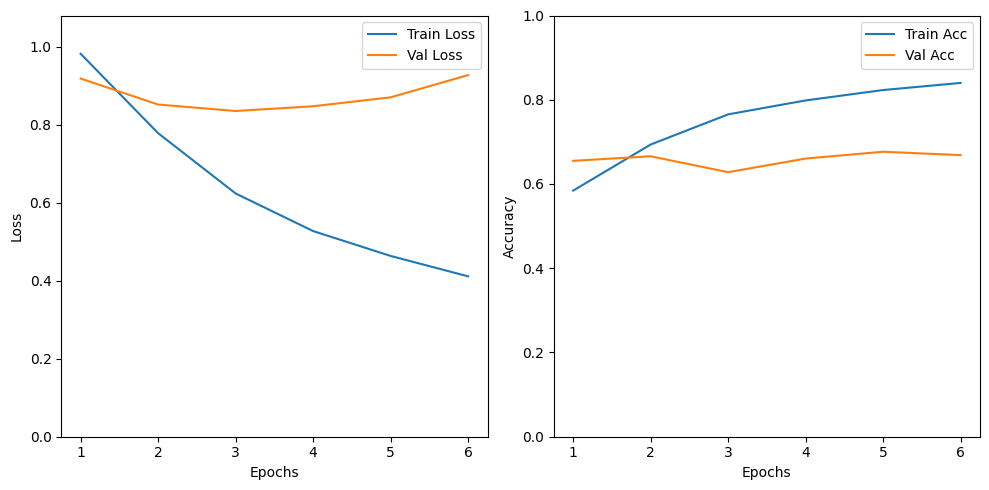

In [15]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

Evaluating BERT

In [ ]:
def evaluate_bert(model_path = "best_bert_model.pth", test_file = "val.json", save_file = "val_task_2.json", batch_size=32):
    """
    Load the trained BERT model and evaluate it on test data.

    Args:
        model_path (str): Path to the saved model file.
        test_file (str): Path to the test dataset.
        batch_size (int): Batch size for evaluation.

    Returns:
        float: Test accuracy.
    """

    # Load test dataset
    test_dataset = FinetuneDataset("bert", test_file, save_file)    
    if torch.cuda.is_available():
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    else:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define model
    model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=4)

    # Load saved model weights
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  # Set to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    correct, total = 0, 0
    with torch.no_grad():
        tqdm_bar = tqdm(test_loader, desc="Evaluating")
        for batch in tqdm_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

evaluate_bert(model_path = "best_bert_model.pth", test_file = "test.json", save_file = "test_task_2.json", batch_size=32)

#### Finetuning BART

In [ ]:
# Load dataset
# train_dataset = FinetuneDataset("bart", "train.json", "/kaggle/input/dataset/train_task_2.json")
# val_dataset = FinetuneDataset("bart", "val.json", "/kaggle/input/dataset/val_task_2.json")
train_dataset = FinetuneDataset("bart", "train.json", "train_task_2.json")
val_dataset = FinetuneDataset("bart", "val.json", "val_task_2.json")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Load BART Model
model = BartForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=4)

# Train
train_loss, val_loss, train_acc, val_acc = finetune(model, train_loader, val_loader, epochs=20, lr=2e-5, model_name = "bart")

Preprocessed data loaded from /kaggle/input/dataset/train_task_2.json
Preprocessed data loaded from /kaggle/input/dataset/val_task_2.json


Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 - Train Loss: 1.0049 - Train Acc: 0.5937 - Val Loss: 1.0657 - Val Acc: 0.5472
Best model saved!


Epoch 2/20 - Train Loss: 0.8890 - Train Acc: 0.6309 - Val Loss: 0.9508 - Val Acc: 0.6065
Best model saved!


Epoch 3/20 - Train Loss: 0.8052 - Train Acc: 0.6714 - Val Loss: 0.9722 - Val Acc: 0.5768
No improvement. Patience: 1/3


Epoch 4/20 - Train Loss: 0.7510 - Train Acc: 0.6927 - Val Loss: 0.9475 - Val Acc: 0.5768
Best model saved!


Epoch 5/20 - Train Loss: 0.6819 - Train Acc: 0.7139 - Val Loss: 0.9377 - Val Acc: 0.6253
Best model saved!


Epoch 6/20 - Train Loss: 0.6128 - Train Acc: 0.7660 - Val Loss: 0.9564 - Val Acc: 0.6361
No improvement. Patience: 1/3


Epoch 7/20 - Train Loss: 0.5812 - Train Acc: 0.7636 - Val Loss: 0.9352 - Val Acc: 0.6253
Best model saved!


Epoch 8/20 - Train Loss: 0.5210 - Train Acc: 0.7957 - Val Loss: 0.9710 - Val Acc: 0.5957
No improvement. Patience: 1/3


Epoch 9/20 - Train Loss: 0.4965 - Train Acc: 0.7997 - Val Loss: 1.0189 - Val Acc: 0.6361
No improvement. Patience: 2/3


Epoch 10/20 - Train Loss: 0.4762 - Train Acc: 0.8119 - Val Loss: 1.0250 - Val Acc: 0.6199
No improvement. Patience: 3/3
Early stopping triggered at epoch 10! Stopping training.

 Training complete. Best Validation Accuracy: 0.6253


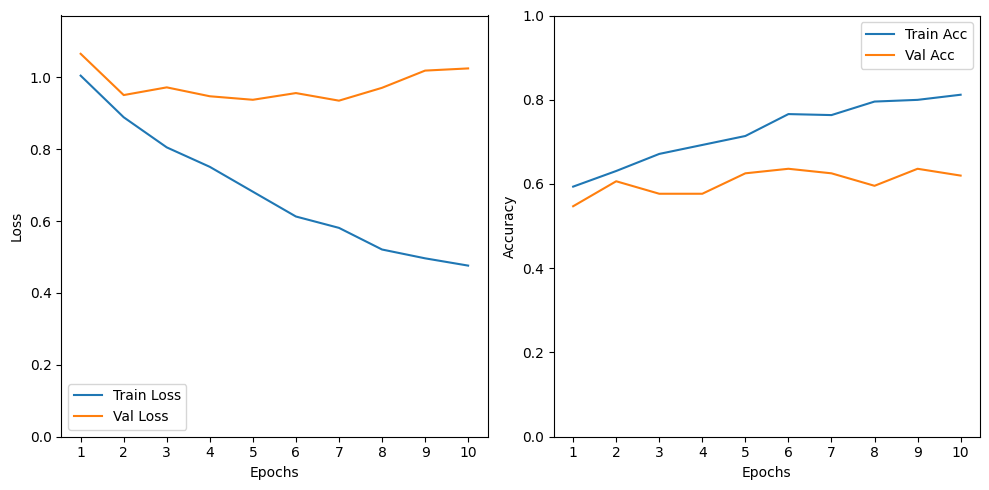

In [18]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

Evaluating BART

In [ ]:
def evaluate_bart(model_path = "best_bart_model.pth", test_file = "val.json", save_file = "val_task_2.json", batch_size=32):
    """
    Load the trained BART model and evaluate it on test data.

    Args:
        model_path (str): Path to the saved model file.
        test_file (str): Path to the test dataset.
        batch_size (int): Batch size for evaluation.

    Returns:
        float: Test accuracy.
    """

    # Load test dataset
    test_dataset = FinetuneDataset("bart", test_file, save_file)    
    if torch.cuda.is_available():
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    else:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define model
    model = BartForSequenceClassification.from_pretrained("facebook/bart-base", num_labels=4)

    # Load saved model weights
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  # Set to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    correct, total = 0, 0
    with torch.no_grad():
        tqdm_bar = tqdm(test_loader, desc="Evaluating")
        for batch in tqdm_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

evaluate_bart(model_path = "best_bart_model.pth", test_file = "test.json", save_file = "test_task_2.json", batch_size=32)

#### Finetuning Roberta

In [ ]:
# Load dataset
# train_dataset = FinetuneDataset("roberta", "train.json", "/kaggle/input/dataset/train_task_2.json")
# val_dataset = FinetuneDataset("roberta", "val.json", "/kaggle/input/dataset/val_task_2.json")
train_dataset = FinetuneDataset("roberta", "train.json", "train_task_2.json")
val_dataset = FinetuneDataset("roberta", "val.json", "val_task_2.json")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Load Roberta Model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

# Train
train_loss, val_loss, train_acc, val_acc = finetune(model, train_loader, val_loader, epochs=20, lr=2e-5, model_name = "roberta")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Preprocessed data loaded from /kaggle/input/dataset/train_task_2.json
Preprocessed data loaded from /kaggle/input/dataset/val_task_2.json


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 - Train Loss: 1.0582 - Train Acc: 0.5653 - Val Loss: 1.0958 - Val Acc: 0.5418
Best model saved!


Epoch 2/20 - Train Loss: 0.9632 - Train Acc: 0.6062 - Val Loss: 1.0069 - Val Acc: 0.5822
Best model saved!


Epoch 3/20 - Train Loss: 0.8984 - Train Acc: 0.6282 - Val Loss: 0.9676 - Val Acc: 0.6011
Best model saved!


Epoch 4/20 - Train Loss: 0.8146 - Train Acc: 0.6680 - Val Loss: 1.0044 - Val Acc: 0.5903
No improvement. Patience: 1/3


Epoch 5/20 - Train Loss: 0.7135 - Train Acc: 0.7204 - Val Loss: 1.0171 - Val Acc: 0.5849
No improvement. Patience: 2/3


Epoch 6/20 - Train Loss: 0.6400 - Train Acc: 0.7541 - Val Loss: 0.9927 - Val Acc: 0.6226
No improvement. Patience: 3/3
Early stopping triggered at epoch 6! Stopping training.

 Training complete. Best Validation Accuracy: 0.6011


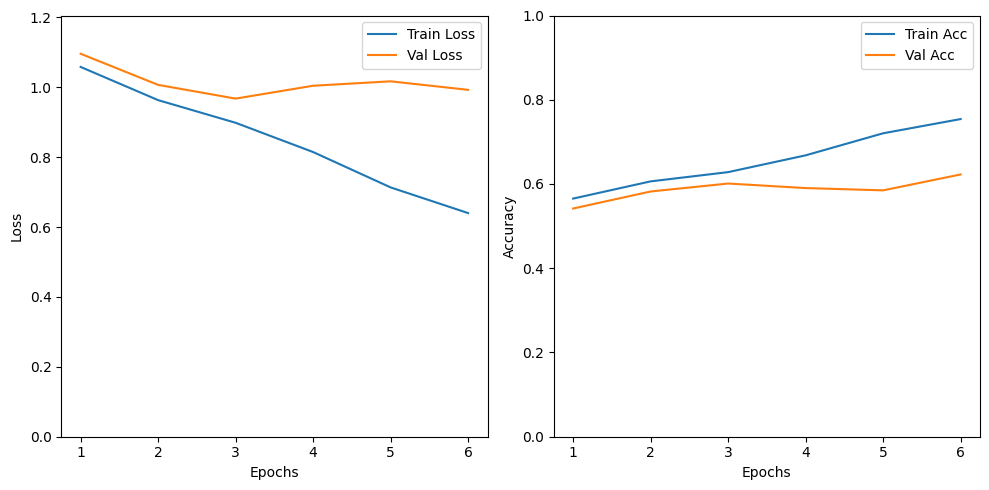

In [20]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

Evaluating Roberta

In [ ]:
def evaluate_roberta(model_path = "best_roberta_model.pth", test_file = "val.json", save_file = "val_task_2.json", batch_size=32):
    """
    Load the trained Roberta model and evaluate it on test data.

    Args:
        model_path (str): Path to the saved model file.
        test_file (str): Path to the test dataset.
        batch_size (int): Batch size for evaluation.

    Returns:
        float: Test accuracy.
    """

    # Load test dataset
    test_dataset = FinetuneDataset("roberta", test_file, save_file)    
    if torch.cuda.is_available():
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    else:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define model
    model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=4)

    # Load saved model weights
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_path))
    else:
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()  # Set to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    correct, total = 0, 0
    with torch.no_grad():
        tqdm_bar = tqdm(test_loader, desc="Evaluating")
        for batch in tqdm_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

evaluate_roberta(model_path = "best_roberta_model.pth", test_file = "test.json", save_file = "test_task_2.json", batch_size=32)